In [1]:
# Reading in data and verify it is the same set as the book
OfflinePath1 = 'C:/Users/casey/Dropbox/SMU_DataScience/MSDS_7333_QuantifyingTheWorld/Homework/CaseStudy1/offline.final.trace.txt'
OfflinePath2 = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/Quant the World/RTLS_CaseStudy/Data/offline_data.txt"

readData = 
  function(filename, 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    submac = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    

    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    offline$posX = round(offline$posX,0)
    offline$posY = round(offline$posY,0)
      
    offline$posXY = paste(offline$posX, offline$posY, sep = "-")
      
    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

processLine = function(x){
    tokens = strsplit(x, "[;=,]")[[1]]
    
    if (length(tokens) == 10)
        return(NULL)
    tmp = matrix(tokens[-(1:10)], ncol=4, byrow = TRUE)
    cbind(matrix(tokens[c(2,4,6:8,10)], nrow = nrow(tmp), ncol=6, byrow=TRUE), tmp)
}

roundOrientation = function(angles) {
    refs = seq(0, by = 45, length = 9)
    q = sapply(angles, function(o) which.min(abs(o-refs)))
    c(refs[1:8], 0)[q]
}
     
offline = readData(OfflinePath1)
# online = readData(OnlinePath1)

null device 
          1

null device 
          1

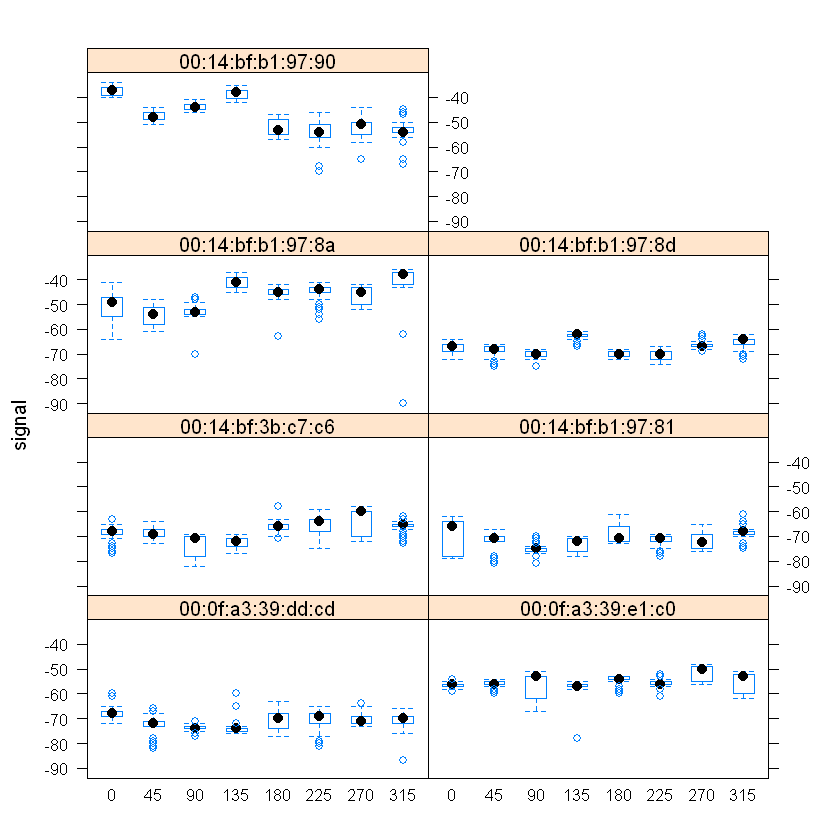

In [3]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12, 
       layout = c(2,4))

par(oldPar)
dev.off()

# summary(offline$signal)

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4,
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

null device 
          1

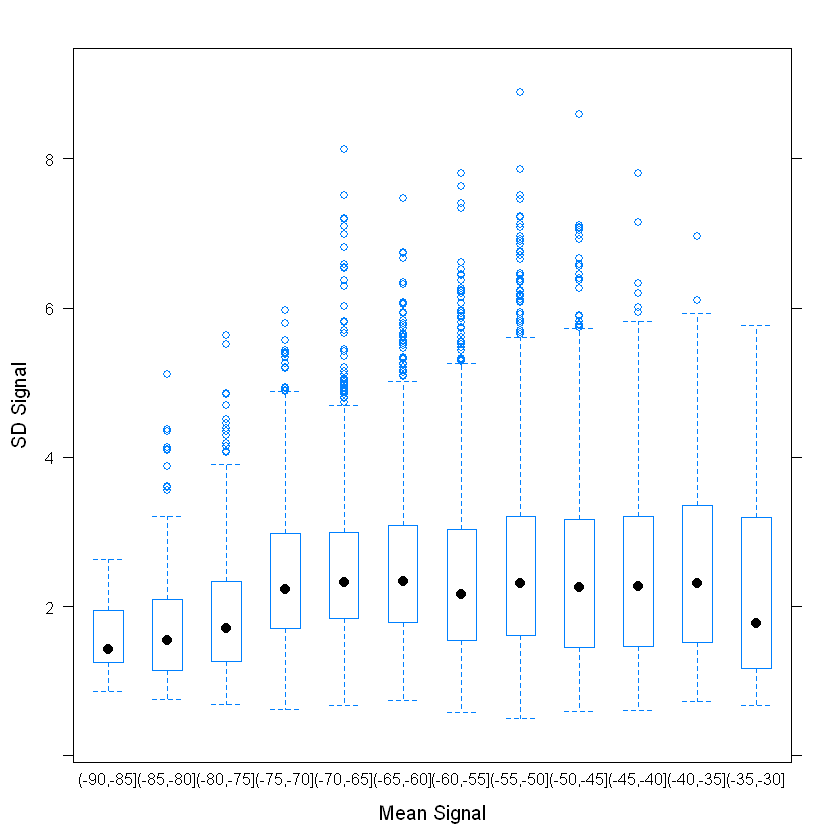

In [88]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary,
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

null device 
          1

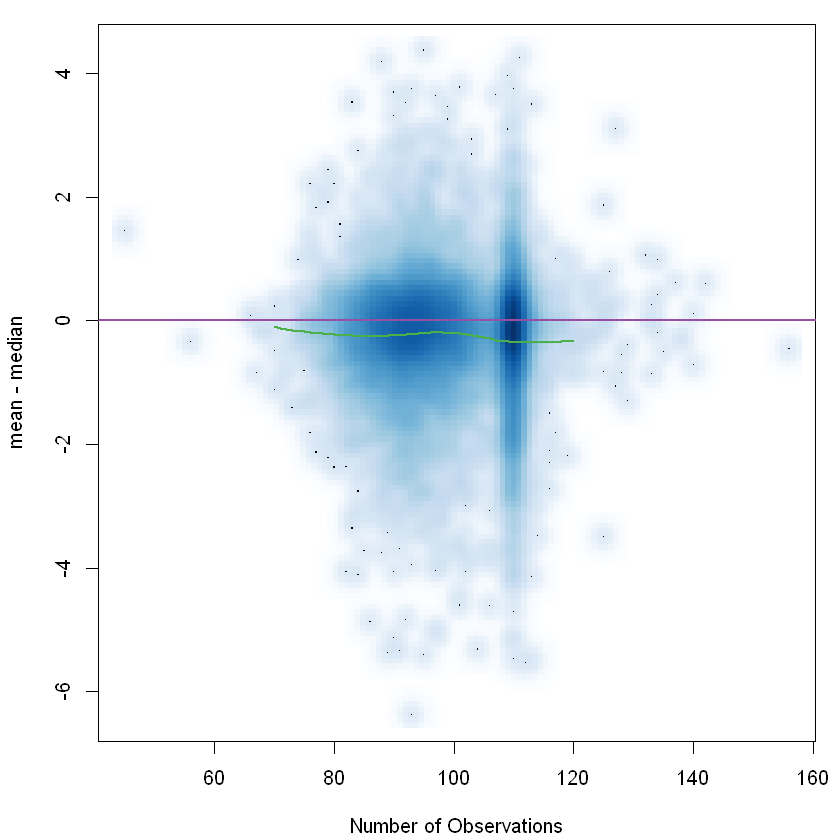

In [89]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))
submac = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

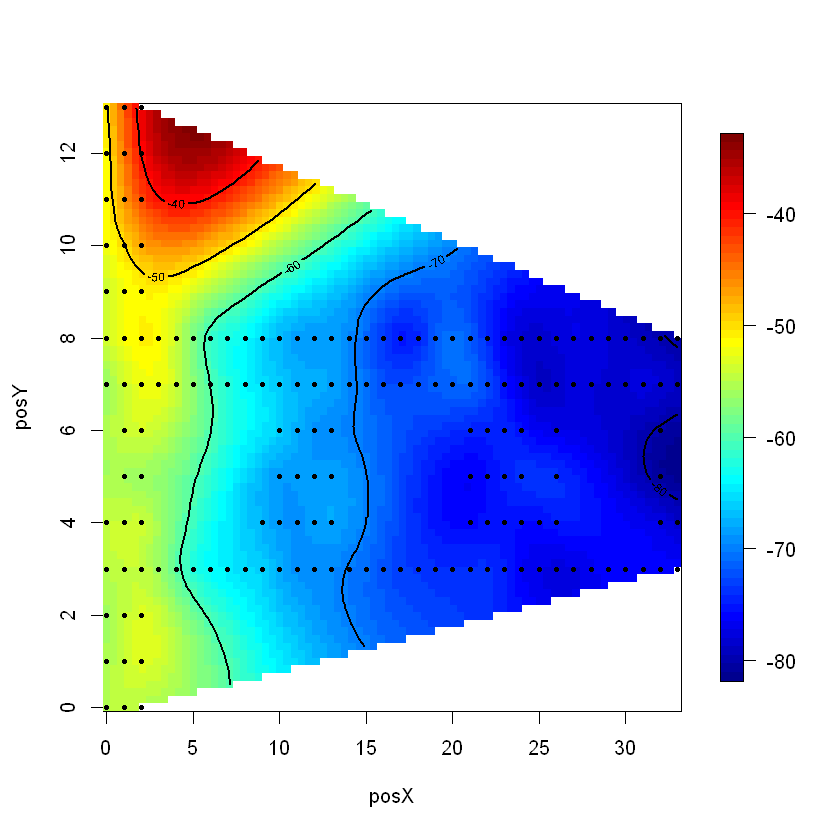

In [90]:
library(fields)

oneAPAngle = subset(offlineSummary, mac == submac[5] & angle == 0)

smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

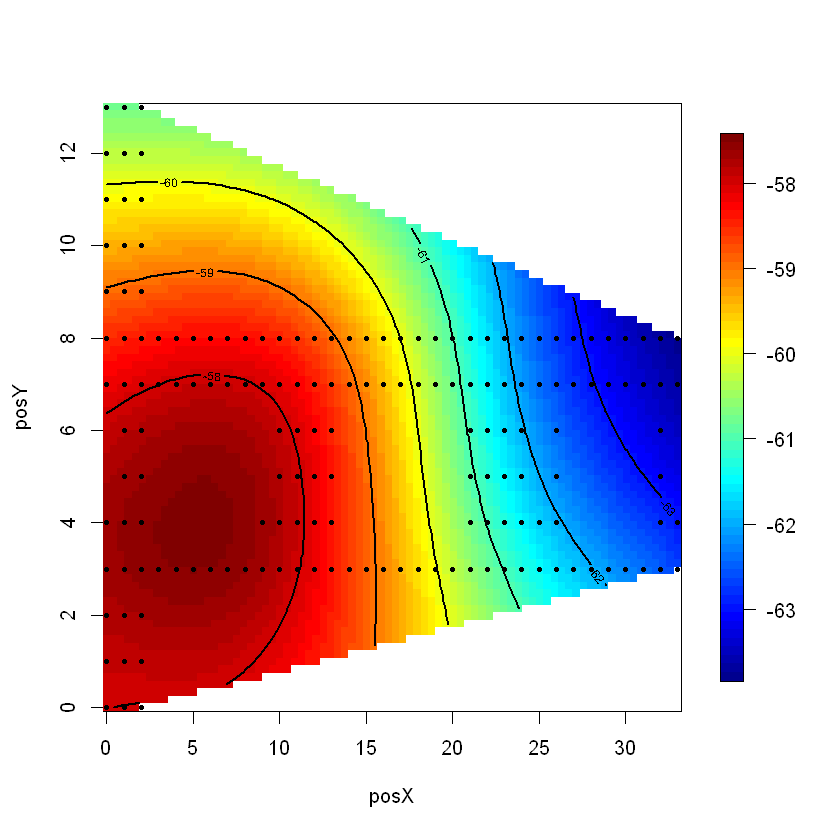

In [91]:
# overall signal strength
library(fields)

allAPAngle = subset(offlineSummary, angle == 0)

smoothSS = Tps(allAPAngle[, c("posX","posY")], 
               allAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(allAPAngle$posX, allAPAngle$posY, pch=19, cex = 0.5)



In [92]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

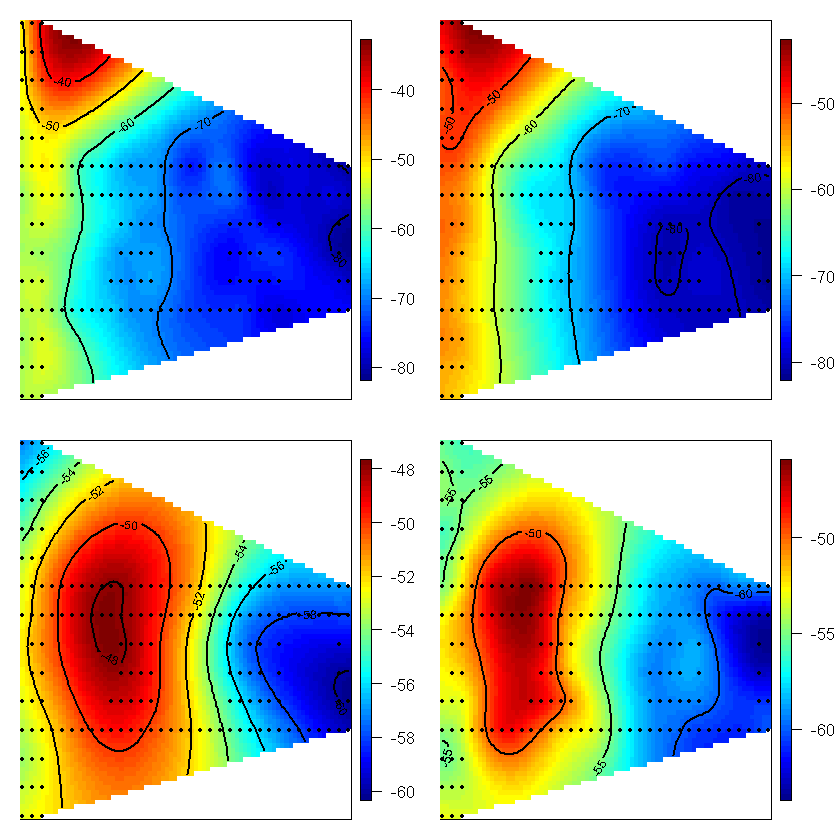

In [93]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = submac[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

offlineSummary = subset(offlineSummary, mac != submac[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(submac[ -2 ], c("x", "y") ))

AP

In [94]:
submac[ rep(c(5, 1), each = 6) ]

[1] "00:14:bf:b1:97:90" "00:14:bf:b1:97:90" "00:14:bf:b1:97:90"
 [4] "00:14:bf:b1:97:90" "00:14:bf:b1:97:90" "00:14:bf:b1:97:90"
 [7] "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0"
[10] "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0"

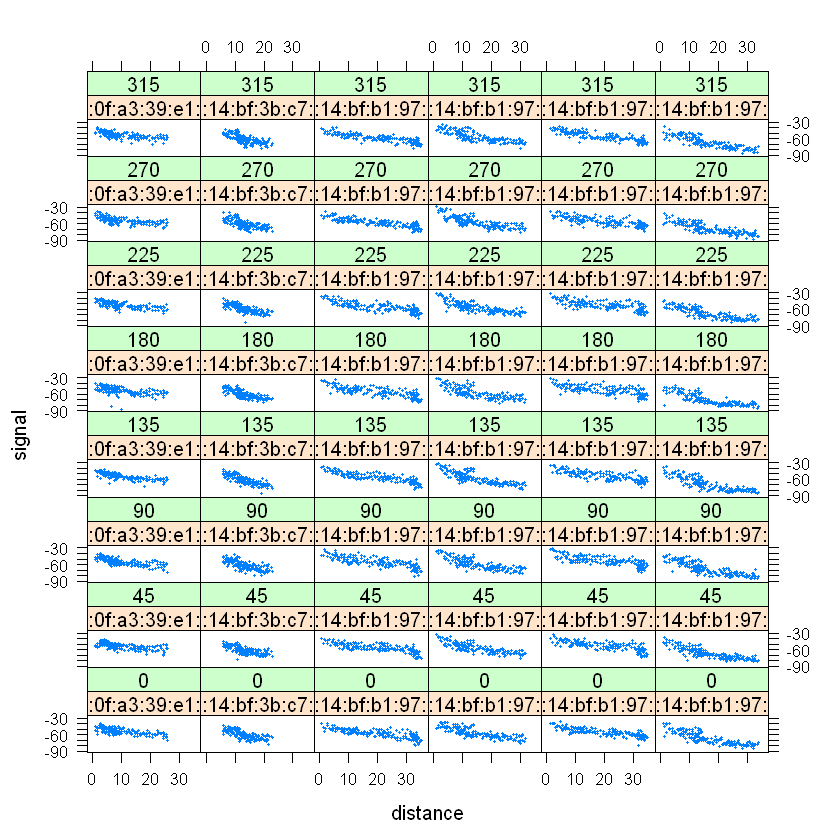

null device 
          1

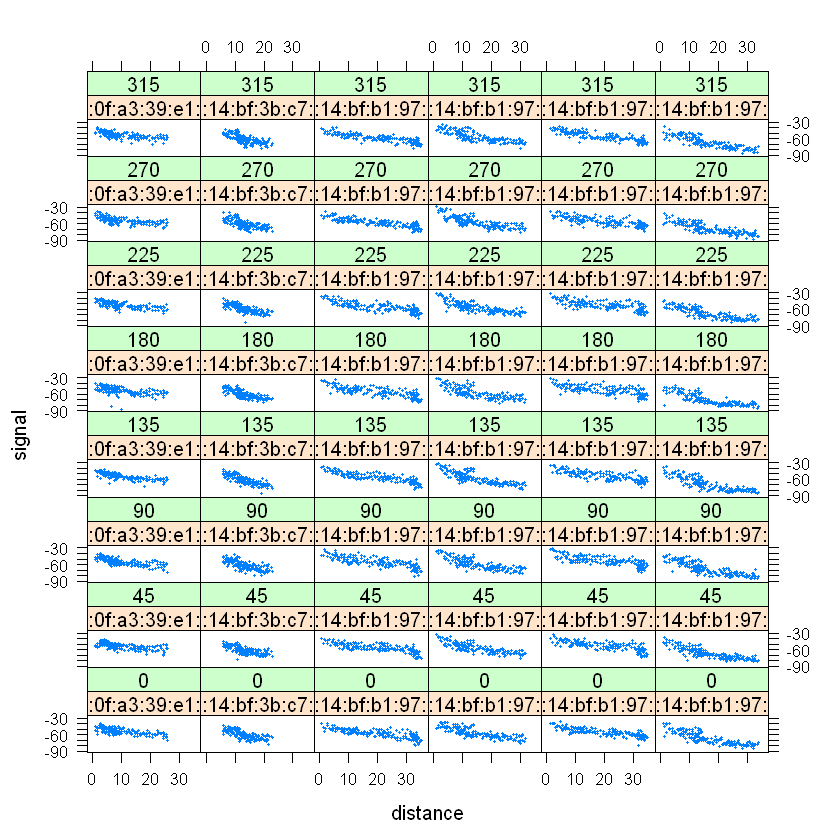

In [95]:
diffs = offlineSummary[ , c("posX", "posY")] - AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)

In [96]:
onlinePath1 = 'C:/Users/casey/Dropbox/SMU_DataScience/MSDS_7333_QuantifyingTheWorld/Homework/CaseStudy1/online.final.trace.txt'

online = readData(onlinePath1, subMacs = macs)

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  



[1] 55

      
         0  45  90 135 180 225 270 315
  0-0    0   0   0 593   0   0   0   0
  0-11   0   0   0   0   0 573   0   0
  0-8  590   0   0   0   0   0   0   0
  0-9    0   0 606   0   0   0   0   0
  1-11 586   0   0   0   0   0   0   0
  1-12   0   0   0   0 583 630   0   0

In [97]:
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] 55 11

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [98]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

In [99]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [100]:
train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}



posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -52.37243         -66.13039         -63.19262        
0-1  0-1   0     1   -52.98182         -65.37177         -63.72941        
0-10 0-10  0    10   -56.34184         -65.67238         -69.16041        
0-11 0-11  0    11   -54.73420         -67.17593         -70.34538        
0-12 0-12  0    12   -56.03030         -70.46493         -72.28758        
0-13 0-13  0    13   -54.55152         -71.19211         -72.58496        
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -35.58063         -64.25411         -55.33780        
0-1  -39.37649         -65.44867         -59.15328        
0-10 -44.71545         -66.85781         -50.45502        
0-11 -48.34689         -66.78383         -54.93054        
0-12 -45.17264         -66.72696         -50.49886        
0-13 -43.32784         -68.72616         -54.48160

[1] 166

In [101]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)



In [102]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

null device 
          1

null device 
          1

[1] 657.0000 327.2222

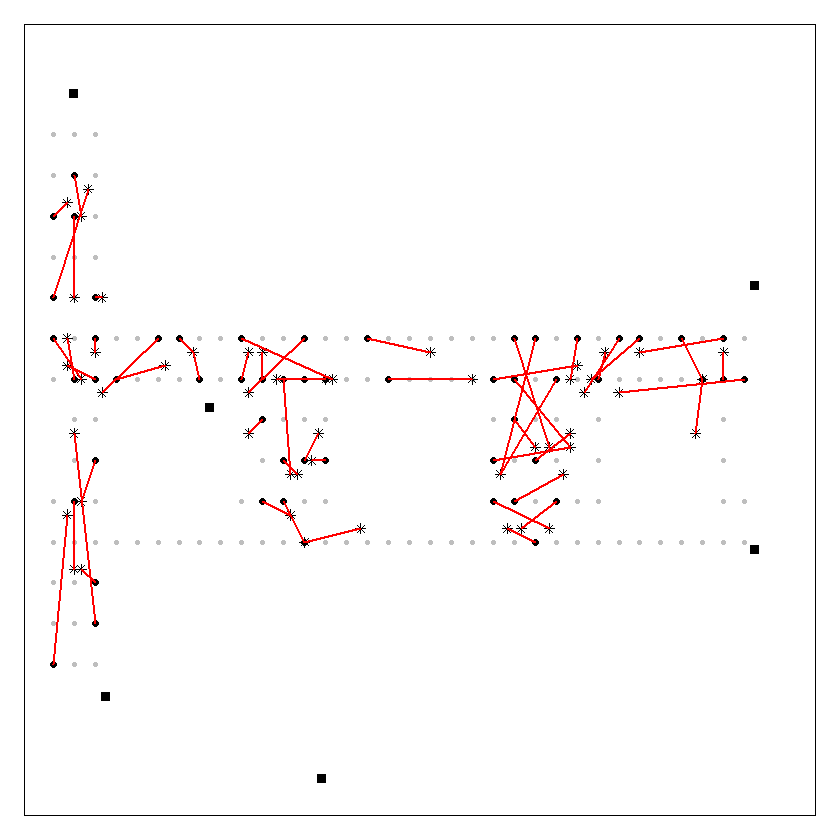

In [103]:
#pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

#pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

In [104]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 657.0000 327.2222

In [105]:
v = 11
# permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [106]:
# offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

Warning message in matrix(avgSS, nrow = 1, ncol = 6, dimnames = list(ans$posXY, :
"data length [7] is not a sub-multiple or multiple of the number of columns [6]"

ERROR: Error in matrix(avgSS, nrow = 1, ncol = 6, dimnames = list(ans$posXY, : length of 'dimnames' [2] not equal to array extent


In [81]:
onlineCVSummary

posXY    posX posY orientation angle 00:0f:a3:39:e1:c0
0.0-0.0  0.0-0.0   0    0    90.3        90   -50.58559        
0.0-1.0  0.0-1.0   0    1   180.1       180   -50.14545        
0.0-10.0 0.0-10.0  0   10     0.9         0   -56.20000        
0.0-11.0 0.0-11.0  0   11   180.4       180   -57.28440        
0.0-12.0 0.0-12.0  0   12   180.5       180   -57.70909        
0.0-13.0 0.0-13.0  0   13    90.2        90   -53.05455        
0.0-2.0  0.0-2.0   0    2   179.2       180   -53.56757        
0.0-3.0  0.0-3.0   0    3     0.2         0   -55.53636        
0.0-4.0  0.0-4.0   0    4   226.0       225   -54.55455        
0.0-7.0  0.0-7.0   0    7    45.4        45   -60.15596        
0.0-8.0  0.0-8.0   0    8     0.7         0   -49.77273        
0.0-9.0  0.0-9.0   0    9    90.1        90   -48.69091        
1.0-0.0  1.0-0.0   1    0    90.7        90   -47.41818        
1.0-1.0  1.0-1.0   1    1   315.0       315   -53.30000        
1.0-10.0 1.0-10.0  1   10    46.0        45   -53.34545        
1.0-11.0 1.0-11.0  1   11   180.3       180   -52.50909        
1.0-12.0 1.0-12.0  1   12   179.6       180   -53.69091        
1.0-13.0 1.0-13.0  1   13   270.1       270   -59.10000        
1.0-2.0  1.0-2.0   1    2   224.5       225   -57.83636        
1.0-3.0  1.0-3.0   1    3   224.9       225   -55.86364        
1.0-4.0  1.0-4.0   1    4    44.8        45   -52.11818        
1.0-5.0  1.0-5.0   1    5    90.3        90   -53.57273        
1.0-6.0  1.0-6.0   1    6   270.0       270   -54.89091        
1.0-7.0  1.0-7.0   1    7   135.4       135   -51.84685        
1.0-8.0  1.0-8.0   1    8   134.9       135   -54.05455        
1.0-9.0  1.0-9.0   1    9   225.1       225   -51.32727        
10.0-3.0 10.0-3.0 10    3     0.4         0   -45.24545        
10.0-4.0 10.0-4.0 10    4    45.3        45   -51.77982        
10.0-5.0 10.0-5.0 10    5   180.4       180   -44.80909        
10.0-6.0 10.0-6.0 10    6   135.4       135   -44.44545        
...      ...      ...  ...  ...         ...   ...              
31.0-8.0 31.0-8.0 31   8    180.9       180   -57.74545        
32.0-3.0 32.0-3.0 32   3      0.0         0   -57.33636        
32.0-4.0 32.0-4.0 32   4     45.8        45   -61.27273        
32.0-5.0 32.0-5.0 32   5    314.2       315   -64.32727        
32.0-6.0 32.0-6.0 32   6    136.0       135   -63.23636        
32.0-7.0 32.0-7.0 32   7     45.2        45   -52.83636        
32.0-8.0 32.0-8.0 32   8    270.9       270   -55.09091        
33.0-3.0 33.0-3.0 33   3    180.5       180   -57.11818        
33.0-4.0 33.0-4.0 33   4     44.9        45   -56.09174        
33.0-7.0 33.0-7.0 33   7    315.0       315   -57.06364        
33.0-8.0 33.0-8.0 33   8    225.7       225   -51.60000        
4.0-3.0  4.0-3.0   4   3    135.5       135   -50.27778        
4.0-7.0  4.0-7.0   4   7    134.3       135   -48.83636        
4.0-8.0  4.0-8.0   4   8    315.3       315   -53.62727        
5.0-3.0  5.0-3.0   5   3    315.5       315   -53.27273        
5.0-7.0  5.0-7.0   5   7     90.5        90   -47.11818        
5.0-8.0  5.0-8.0   5   8     45.8        45   -46.42727        
6.0-3.0  6.0-3.0   6   3    270.1       270   -49.41818        
6.0-7.0  6.0-7.0   6   7     89.0        90   -40.50909        
6.0-8.0  6.0-8.0   6   8      0.1         0   -48.11818        
7.0-3.0  7.0-3.0   7   3     90.3        90   -41.03670        
7.0-7.0  7.0-7.0   7   7    271.5       270   -40.61261        
7.0-8.0  7.0-8.0   7   8     46.3        45   -54.83636        
8.0-3.0  8.0-3.0   8   3    135.2       135   -49.82727        
8.0-7.0  8.0-7.0   8   7     89.6        90   -48.18349        
8.0-8.0  8.0-8.0   8   8    225.3       225   -46.36364        
9.0-3.0  9.0-3.0   9   3      0.4         0   -49.41441        
9.0-4.0  9.0-4.0   9   4    224.8       225   -41.86111        
9.0-7.0  9.0-7.0   9   7    180.4       180   -47.00000        
9.0-8.0  9.0-8.0   9   8    180.7       180   -54.35455        
         00:14:bf:3b:c7:c6 00:14:bf:b1:97

In [82]:
permuteLocs

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
 [1,] 19-3 3-7  2-7  3-3  28-8 11-5 22-8 33-8 5-3  10-8  1-3  
 [2,] 28-3 11-4 1-7  30-3 25-3 13-7 21-5 18-3 27-8 33-7  9-8  
 [3,] 2-10 14-7 18-7 31-7 1-0  2-2  26-4 0-1  24-4 19-7  17-8 
 [4,] 22-4 11-8 16-8 15-3 32-5 9-7  28-7 2-13 26-8 8-7   22-5 
 [5,] 13-8 15-8 18-8 1-10 3-8  20-8 4-8  24-7 2-0  2-9   13-3 
 [6,] 0-2  5-7  7-7  10-3 4-3  23-8 11-6 0-3  22-7 32-8  31-3 
 [7,] 27-3 27-7 13-6 1-13 26-5 26-6 14-8 22-6 12-6 29-3  19-8 
 [8,] 2-6  12-3 25-4 20-3 2-12 7-8  2-4  10-5 25-7 16-7  21-8 
 [9,] 33-3 0-10 0-8  26-7 10-4 23-4 9-4  23-5 6-7  32-7  6-3  
[10,] 24-3 10-6 1-6  17-3 1-1  20-7 9-3  30-8 32-3 24-5  5-8  
[11,] 2-3  2-1  24-8 11-3 15-7 17-7 4-7  0-0  0-4  13-4  21-3 
[12,] 12-8 16-3 1-8  29-7 12-4 1-11 32-4 2-11 23-6 13-5  1-5  
[13,] 31-8 29-8 8-3  25-8 12-7 32-6 33-4 0-9  30-7 14-3  1-12 
[14,] 0-12 0-7  22-3 7-3  0-11 6-8  0-13 23-3 2-8  11-7  26-3 
[15,] 21-4 10-7 21-6 8-8  1-2  24-6 21-7 12-5 1-9  23-7  2-5

In [78]:
actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

ERROR: Error in rowSums((estXY - actualXY)^2): object 'estFold' not found


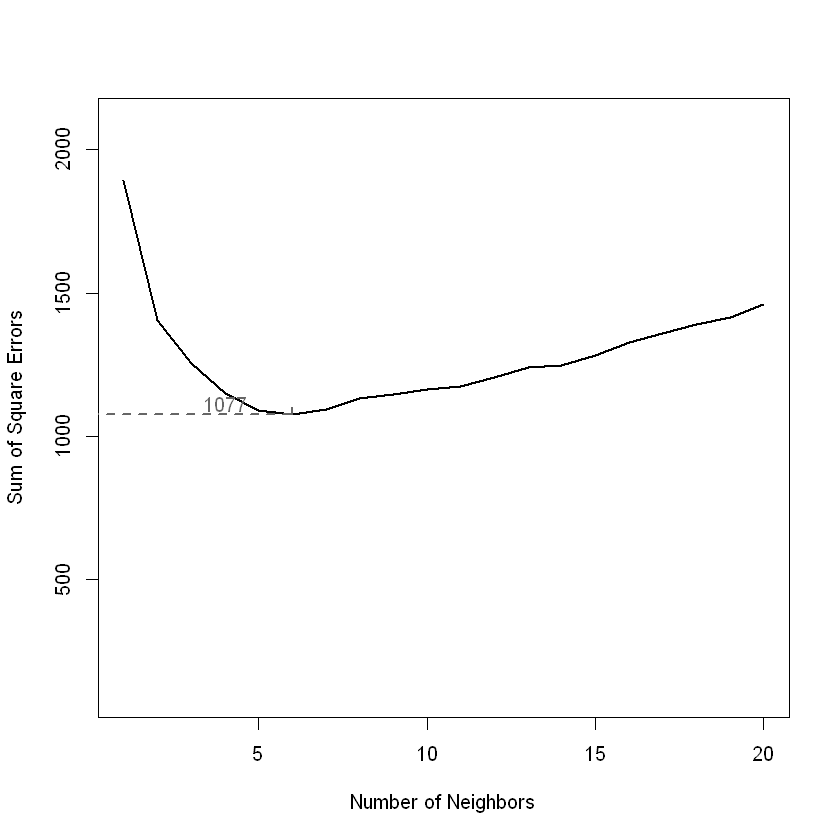

In [29]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
#par(oldPar)
#dev.off()

In [35]:
#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))


estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 6)

calcError(estXYk5, actualXY)

[1] 272

In [31]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

In [32]:
findWNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1,
                function(x) abs(x - newSignal))
  dists = apply(diffs, 2, function(x) (1/x)/sum(1/x) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [34]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  trainSubset$dist=dists
  closest = order(dists)
  return(trainSubset[closest, 1:4 ])}

In [ ]:
dists[order(dists)]

In [ ]:
1/(1/6.99+1/9.06+1/10.7)

In [ ]:
2.88/6.99

In [ ]:
2.88/9.06

In [ ]:
a/d

In [ ]:
function(x,y)